# Extract single reads

Date: 29 Jul 2025

Using https://github.com/MichalRozenwald/epiCausality/blob/main/Extract_single_reads_%26_LR_2024Apr16.ipynb 
and https://github.com/MichalRozenwald/epiCausality/blob/main/gm12878_deepCTCF_updated_extract_reads.ipynb 

In [17]:
from dimelo import parse_bam, plot_enrichment_profile, plot_reads, load_processed, utils
import pysam
import platform

import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from matplotlib.axes import Axes
import numpy as np
import pandas as pd

print('System:',platform.system())
print('Release:',platform.release())
print('Version:',platform.version())
print('Processor:',platform.processor())

#  Pyton version
import sys
print(sys.version)
     

System: Linux
Release: 6.8.0-60-generic
Version: #63~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 22 19:00:15 UTC 2
Processor: x86_64
3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]


In [18]:
ref_genome_v1_1_file = Path('/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta') #'./test/output/chm13.draft_v1.1.fasta')
ref_genome_v1_1_file

PosixPath('/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta')

In [19]:

t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'

ref_seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162, 206586192) #t2t v11: 206586162,206586192)
# seq = pysam.FastaFile(ref_genome_v1_0_gm_path).fetch('chr1',206586331, 206586361) #t2t v11: 206586162,206586192)
print(ref_seq), print(len(ref_seq))
ref_seq_list =  [s for s in ref_seq]
# plt.xticks(range(len(ref_seq_list)), ref_seq_list, size='small')

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC
30


In [20]:
output_dir = Path("./dimelo_v2_output")
# Path('/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package') # './test/output')

output_dir.mkdir(exist_ok=True)
output_dir

PosixPath('dimelo_v2_output')

In [21]:
! ls "/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_UNEDITED_Day28/merged_outputs/sorted_align_t2t_v1_1_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merged.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"

# "/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_CROFF_Day28/mergered_outputs/sort_merge_sort_align_t2t_v1_1_trim_20250721_nCATs_Tcells_CROFF_Day28_minion_run2_day8.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"

#  "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9/pod5_converted_basecall/5mCG/to_t2t_v1_1/"

/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_UNEDITED_Day28/merged_outputs/sorted_align_t2t_v1_1_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merged.dna_r9.4.1_e8_sup@v3.3.5mCG.bam


In [22]:
unedited_bam_path = "/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_UNEDITED_Day28/merged_outputs/sorted_align_t2t_v1_1_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merged.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"

#  "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TcellsPrES_unedit_P2R9/passed_fast5/5mCG/to_t2t_v1_1/sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"
unedited_bam_path

'/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_UNEDITED_Day28/merged_outputs/sorted_align_t2t_v1_1_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merged.dna_r9.4.1_e8_sup@v3.3.5mCG.bam'

No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.7 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in chm13.draft_v1.1.fasta   0% | 00:00

          | Step 2: Parse regions in sorted_align_t2t_v1_1_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_me…

          |    0%

          | Transferring 40 from reads.CG,0.txt into reads.combined_basemods.h5, new size 40   0% | 00:00<?

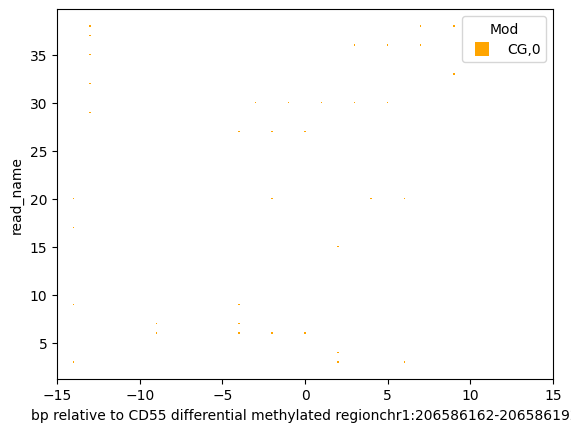

In [31]:
def extract_from_bam(bam_path, ref_genome_file, output_dir, 
                    window_size=None, threshold_mC=0.99, num_cores=32,
                    regions = 'chr1:206586162-206586192',
                    motifs=['CG,0'],
                    output_name='cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09',):
    """
    Processes a BAM file using the parse_bam.extract function and plots the extracted reads.

    Parameters:
        bam_path (str): Path to the input BAM file.
        ref_genome_file (str): Path to the reference genome file.
        output_dir (str): Directory to store output files.
        window_size (int, optional): Window size for extraction. Defaults to None.
        threshold_mC (float, optional): Threshold for methylation. Defaults to 0.99.
        num_cores (int, optional): Number of cores for processing. Defaults to 32.

    Returns:
        extract_file, extract_regions
    """

    extract_file, extract_regions  = parse_bam.extract(
        input_file=bam_path,
        output_name=output_name,
        ref_genome=ref_genome_file,
        output_directory=output_dir,
        regions=regions,
        motifs=motifs,
        thresh=threshold_mC,
        window_size=window_size,
    )

    plot_reads.plot_reads(
        extract_file,
        t2t_v1_1_cd55_30bps,
        motifs=motifs,
        window_size=window_size,
        sort_by=['shuffle', 'strand'],
        s=1
    )

    plt.xlabel('bp relative to CD55 differential methylated region' + str(regions) )
    plt.show()

    return(extract_file, extract_regions )


# Example usage
bam_path = unedited_bam_path
threshold_mC=0.7
# threshold_mC=0.9
# threshold_mC=0.99

window_size = None # 4000
# window_size = 4000

t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'
regions = t2t_v1_1_cd55_30bps

motifs=['CG,0']
output_name='cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09'
# outname = f'cd55_window{window_size}'
num_cores = 32


extract_file, extract_regions = extract_from_bam(
    bam_path=unedited_bam_path,
    ref_genome_file=ref_genome_v1_1_file,
    output_dir=output_dir,
    window_size=window_size,   # 4000,
    threshold_mC=threshold_mC,  # 0.99
    regions = regions,         # 'chr1:206586162-206586192',
    motifs=motifs,
    output_name=output_name, #'cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09',
)


In [24]:
# extract_from_bam(
#     bam_path=unedited_bam_path,
#     ref_genome_file=ref_genome_v1_1_file,
#     output_dir=output_dir,
#     window_size=window_size, # 4000,
#     threshold_mC= 0.75, #  threshold_mC, #0.99
#     regions = 'chr1:206586162-206586192',
#     output_name='cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09',
# )

In [25]:
extract_file, extract_regions

(PosixPath('dimelo_v2_output/cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09/reads.combined_basemods.h5'),
 PosixPath('dimelo_v2_output/cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09/regions.processed.bed'))

In [26]:
# ! python3 -m pip install biopython

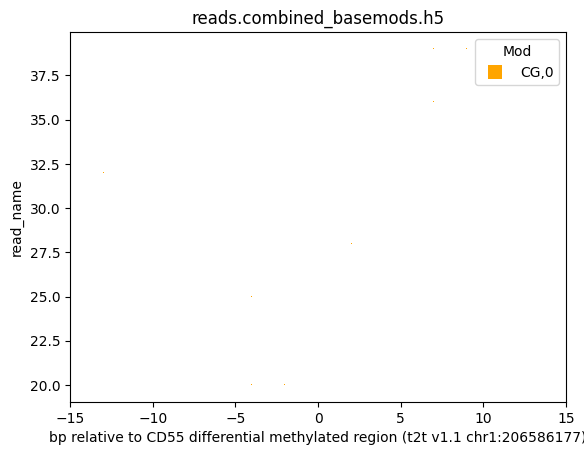

In [27]:
plot_reads.plot_reads(  
    extract_file,
    t2t_v1_1_cd55_30bps, # "chr1:206586162-206586192", #bed_region,
    ['CG,0'],
    window_size = window_size, #4000,
    sort_by=['shuffle', 'strand'],
    thresh=threshold_mC,  # 0.99
    # s=3
)
plt.xlabel('bp relative to CD55 differential methylated region (t2t v1.1 chr1:206586177)')
plt.title(Path(extract_file).name)
plt.show()
     


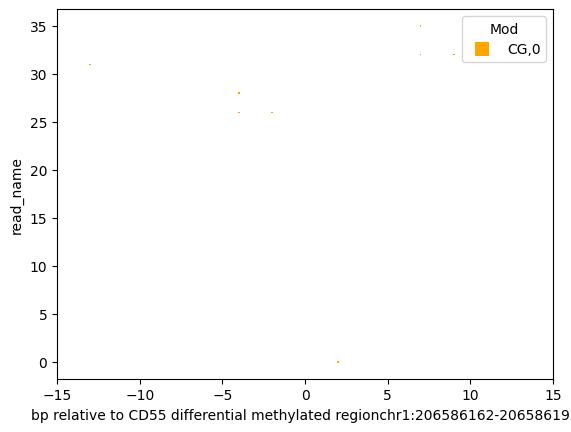

In [11]:
plot_reads.plot_reads(
    extract_file,
    t2t_v1_1_cd55_30bps,
    motifs=motifs,
    window_size=window_size,
    sort_by=['shuffle', 'strand'],
    s=1
)

plt.xlabel('bp relative to CD55 differential methylated region' + str(regions) )
plt.show()

Using gm12878_deepCTCF_updated_extract_reads
 https://github.com/MichalRozenwald/epiCausality/blob/main/gm12878_deepCTCF_updated_extract_reads.ipynb 

In [35]:
extract_file

PosixPath('dimelo_v2_output/cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09/reads.combined_basemods.h5')

In [36]:
reads, read_names, mods, regions_dict = load_processed.readwise_binary_modification_arrays(
              file=extract_file,
              regions=regions,
              motifs=motifs,
              window_size=None, #window_size,
)
      # thresh = thresh,
      # relative = relative,
      # sort_by = sort_by,
    
# Convert data frame where each row represents a read to a data frame where each row represents a single modified position in a read
df = pd.DataFrame({
    'read_name': read_names,
    'mod': mods,
    'pos': reads
}).explode('pos')
df

,read_name,mod,pos
0,0,"CG,0",-14
1,0,"CG,0",-2
2,0,"CG,0",4
3,0,"CG,0",6
4,1,"CG,0",-13
5,1,"CG,0",7
6,1,"CG,0",9
7,3,"CG,0",2
8,4,"CG,0",-14
9,4,"CG,0",2


In [37]:
len(np.unique(df['read_name']))

17

In [38]:

df['pos_shifted'] = df['pos'] + 15
df

,read_name,mod,pos,pos_shifted
0,0,"CG,0",-14,1
1,0,"CG,0",-2,13
2,0,"CG,0",4,19
3,0,"CG,0",6,21
4,1,"CG,0",-13,2
5,1,"CG,0",7,22
6,1,"CG,0",9,24
7,3,"CG,0",2,17
8,4,"CG,0",-14,1
9,4,"CG,0",2,17


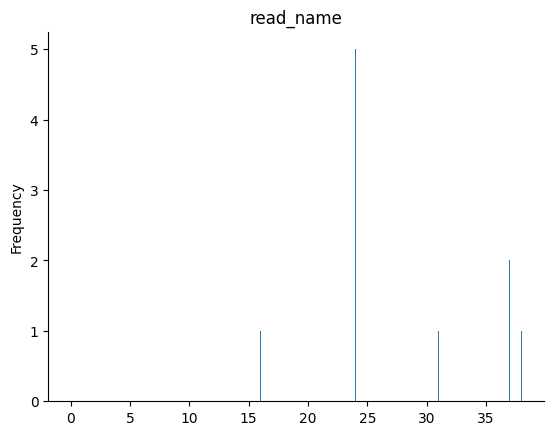

In [39]:
# @title read_name

from matplotlib import pyplot as plt
df['read_name'].plot(kind='hist', bins=1600, title='read_name')
plt.gca().spines[['top', 'right',]].set_visible(False)

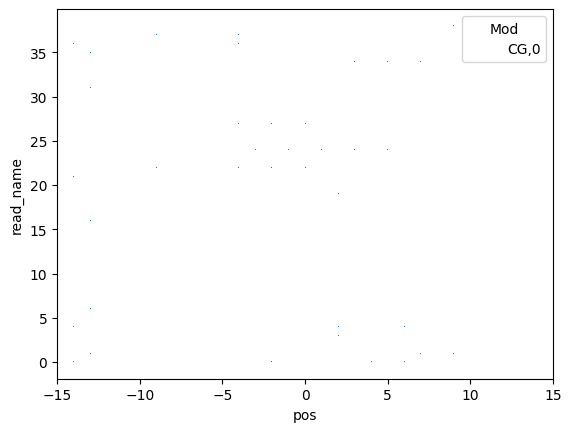

In [40]:
# Link to function https://github.com/streetslab/dimelo/blob/modkit_parsing_beta/dimelo/plot_reads.py#L56C1-L79C22

# mod_file_name = Path(mod_file_name)
# bed_file_name = Path(bed_file_name)
size = 0.5 # kwargs.pop('s', 0.5)

# palette = kwargs.pop('palette', {})
# merged_palette = {**utils.DEFAULT_COLORS, **palette}

axes = sns.scatterplot(
    data=df,
    x="pos",
    y="read_name",
    hue="mod",
    # palette=colors,
    s=size,
    marker="s",
    linewidth=0,
    # palette = merged_palette,
    # **kwargs
)
# Retrieve the existing legend
legend = axes.legend_
# legend = axes.get_legend

# Update legend properties
if legend is not None:
    legend.set_title('Mod')
    # for handle in legend.legendHandles:
    #     handle.set_markersize(10)  # Set a larger marker size for legend

relative = True
if relative:
    region1_start,region1_end,_ = next(iter(regions_dict.values()))[0]
    effective_window_size = (region1_end-region1_start)//2
    axes.set_xlim([-effective_window_size,effective_window_size])

# return axes

In [41]:
df.groupby("read_name").count() #["pos"].count()

,mod,pos,pos_shifted
read_name,,,
0,4,4,4
1,3,3,3
3,1,1,1
4,3,3,3
6,1,1,1
16,1,1,1
19,1,1,1
21,1,1,1
22,4,4,4


In [42]:
len(read_names), len(np.unique(df['read_name']))

(37, 17)

In [43]:
read_names_unique = np.unique(df['read_name'])
num_reads = len(read_names_unique)
num_reads

17

In [44]:
read_names_unique

array([ 0,  1,  3,  4,  6, 16, 19, 21, 22, 24, 27, 31, 34, 35, 36, 37, 38])

In [45]:
reads_dict_nums = dict(enumerate(read_names_unique))
reads_dict_nums

{0: np.int64(0),
 1: np.int64(1),
 2: np.int64(3),
 3: np.int64(4),
 4: np.int64(6),
 5: np.int64(16),
 6: np.int64(19),
 7: np.int64(21),
 8: np.int64(22),
 9: np.int64(24),
 10: np.int64(27),
 11: np.int64(31),
 12: np.int64(34),
 13: np.int64(35),
 14: np.int64(36),
 15: np.int64(37),
 16: np.int64(38)}

In [46]:
reads_dict = dict()

for i in range(len(read_names_unique)):
  reads_dict[read_names_unique[i]] = i
reads_dict

{np.int64(0): 0,
 np.int64(1): 1,
 np.int64(3): 2,
 np.int64(4): 3,
 np.int64(6): 4,
 np.int64(16): 5,
 np.int64(19): 6,
 np.int64(21): 7,
 np.int64(22): 8,
 np.int64(24): 9,
 np.int64(27): 10,
 np.int64(31): 11,
 np.int64(34): 12,
 np.int64(35): 13,
 np.int64(36): 14,
 np.int64(37): 15,
 np.int64(38): 16}

In [47]:
padded_reads = np.zeros([num_reads, 30])
padded_reads

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0

In [48]:
padded_reads.shape


(17, 30)

In [49]:
# SWITCH TO Nans -> to distriguish empty values from unmethylated
padded_reads = padded_reads + np.nan
padded_reads.shape, padded_reads

((17, 30),
 array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, n

In [50]:
for i in range(len(df['read_name'])):
  # df['pos_shifted']:
  padded_reads[reads_dict[df['read_name'][i]], df['pos_shifted'][i]] = 1
padded_reads

array([[nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         1., nan, nan, nan, nan, nan,  1., nan,  1., nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan,  1., nan,  1., nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan,  1., nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan,  1., nan, nan, nan,  1., nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [51]:
i = 0
reads_dict[df['read_name'][i]],

(0,)

In [52]:
df['read_name'][i]

np.int64(0)

In [53]:
padded_reads[reads_dict[df['read_name'][i]]]


array([nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        1., nan, nan, nan, nan, nan,  1., nan,  1., nan, nan, nan, nan,
       nan, nan, nan, nan])

In [54]:
df[df["read_name"] == df['read_name'][i]]

,read_name,mod,pos,pos_shifted
0,0,"CG,0",-14,1
1,0,"CG,0",-2,13
2,0,"CG,0",4,19
3,0,"CG,0",6,21


In [55]:
df["read_name"] 

0      0
1      0
2      0
3      0
4      1
5      1
6      1
7      3
8      4
9      4
10     4
11     6
12    16
13    19
14    21
15    22
16    22
17    22
18    22
19    24
20    24
21    24
22    24
23    24
24    27
25    27
26    27
27    31
28    34
29    34
30    34
31    35
32    36
33    36
34    37
35    37
36    38
Name: read_name, dtype: int64

In [56]:
padded_reads


array([[nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         1., nan, nan, nan, nan, nan,  1., nan,  1., nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan,  1., nan,  1., nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan,  1., nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan,  1., nan, nan, nan,  1., nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan,

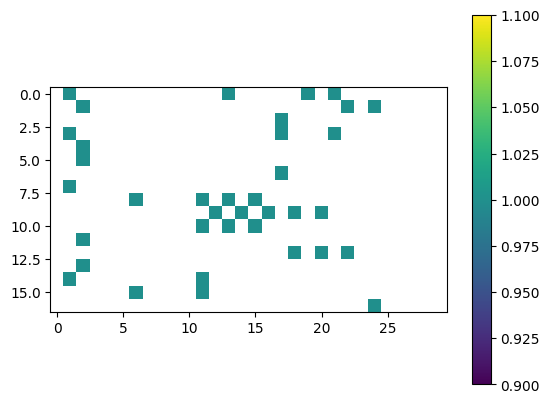

In [57]:

plt.imshow(padded_reads[:100]) # np.random.random((50,50)))
plt.colorbar()
plt.show()

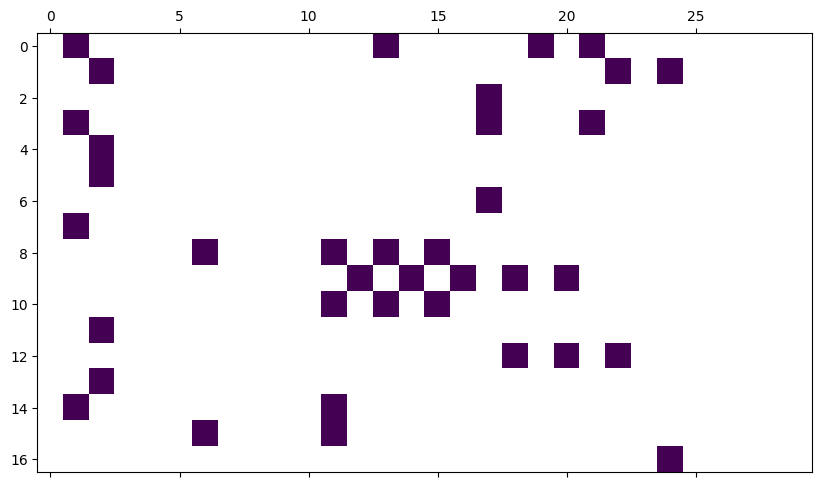

In [58]:


plt.figure(figsize=(10,50))
plt.matshow(padded_reads, fignum=1)


In [59]:
padded_reads_df = pd.DataFrame(padded_reads)
padded_reads_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
padded_reads_df.columns = ref_seq_list
padded_reads_df

,C,C,G,C,C,C,C,G,A,G,...,G,C,G,C,G,C,G,C,A,C
0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
padded_reads_df.describe()

,C,C,G,C,C,C,C,G,A,G,...,G,C,G,C,G,C,G,C,A,C
count,0.0,4.0,5.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,2.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
min,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
25%,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
50%,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
75%,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
max,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [62]:
# Save mC profiles np.ARRAY!
padded_reads.shape, padded_reads

((17, 30),
 array([[nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          1., nan, nan, nan, nan, nan,  1., nan,  1., nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan,  1., nan,  1., nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan,  1., nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan,  1., nan, nan, nan,  1., nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, n

In [63]:
output_dir

PosixPath('dimelo_v2_output')

In [64]:
save_folder_path = output_dir # + "etracted_reads"
save_folder_path

PosixPath('dimelo_v2_output')

In [43]:
threshold_mC

0.99

In [44]:
bam_path

'/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TcellsPrES_unedit_P2R9/passed_fast5/5mCG/to_t2t_v1_1/sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.1_e8_sup@v3.3.5mCG.bam'

In [45]:
# cd55_30pbRIO_padded_reads.npy
# TODO: add info, dates, path
save_name = "deepCTCF_thresh" + str(threshold_mC) + "_cd55_30pbRIO_padded_reads" 
save_name_np = save_name + ".npy"

np.save(Path(save_folder_path, save_name_np), padded_reads)

Path(save_folder_path, save_name_np) 

PosixPath('dimelo_v2_output/deepCTCF_thresh0.99_cd55_30pbRIO_padded_reads.npy')

# Combine into single .py

System: Linux
Release: 6.8.0-60-generic
Version: #63~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 22 19:00:15 UTC 2
Processor: x86_64
3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]
CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC
30
align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam
chr1_sort_align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam
chr1_sort_align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam.bai
sort_align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam
sort_align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.bam.bai
summary_sort_align_t2t_v1_1_trim_20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9.dna_r9.4.1_e8_sup@v3.3.5mCG.tsv
No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.99 will be treated as coming from rang

          | Step 1: Identify motif locations in chm13.draft_v1.1.fasta   0% | 00:00

          | Step 2: Parse regions in sorted_align_t2t_v1_1_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_me…

          |    0%

          | Transferring 40 from reads.CG,0.txt into reads.combined_basemods.h5, new size 40   0% | 00:00<?

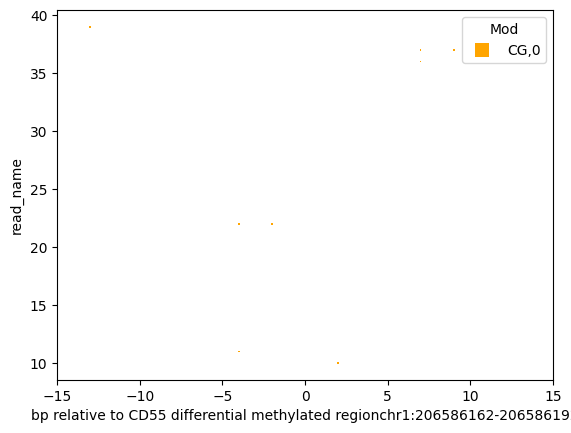

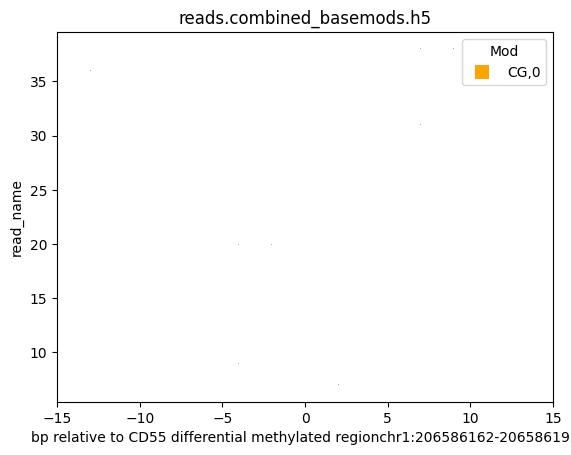

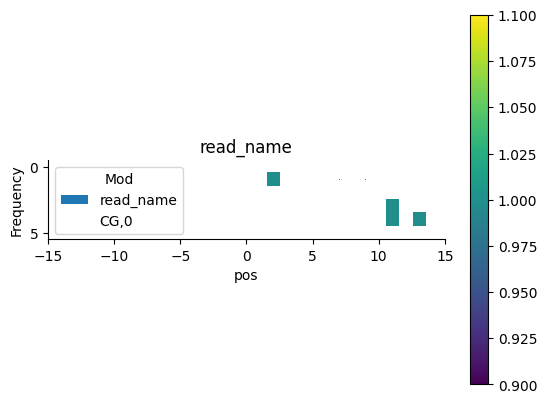

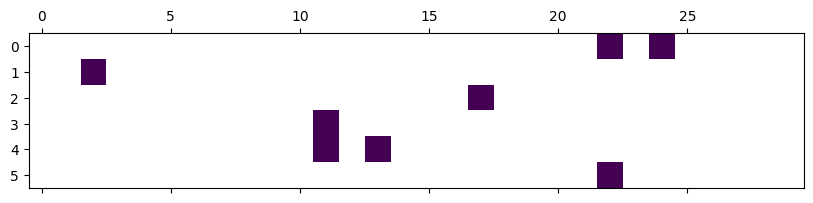

In [65]:
def main():
    """Main function to execute all extracted code sequentially."""
    from dimelo import parse_bam, plot_enrichment_profile, plot_reads, load_processed, utils
    import pysam
    import platform
    
    import matplotlib.pyplot as plt
    from pathlib import Path
    import seaborn as sns
    from matplotlib.axes import Axes
    import numpy as np
    import pandas as pd
    
    print('System:', platform.system())
    print('Release:', platform.release())
    print('Version:', platform.version())
    print('Processor:', platform.processor())
    
    # Python version
    import sys
    print(sys.version)
         
    ref_genome_v1_1_file = Path('/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta')
    
    t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'
    
    ref_seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1', 206586162, 206586192)
    print(ref_seq), print(len(ref_seq))
    ref_seq_list = [s for s in ref_seq]

    output_dir = Path("./dimelo_v2_output")
    output_dir.mkdir(exist_ok=True)
    
    !ls "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TPrES_CROFF90prD6_P2R9/pod5_converted_basecall/5mCG/to_t2t_v1_1/"

    # unedited_bam_path = "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TcellsPrES_unedit_P2R9/passed_fast5/5mCG/to_t2t_v1_1/sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"
    unedited_bam_path = "/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_UNEDITED_Day28/merged_outputs/sorted_align_t2t_v1_1_trim_20250721_nCATs_Tcells_UNEDITED_Day28_minion_merged.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"

# "/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_CROFF_Day28/mergered_outputs/sort_merge_sort_align_t2t_v1_1_trim_20250721_nCATs_Tcells_CROFF_Day28_minion_run2_day8.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"

    def extract_from_bam(bam_path, ref_genome_file, output_dir, 
                        window_size=None, threshold_mC=0.99, num_cores=32,
                        regions='chr1:206586162-206586192',
                        motifs=['CG,0'],
                        output_name='cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09'):
        """
        Processes a BAM file using the parse_bam.extract function and plots the extracted reads.

        Parameters:
            bam_path (str): Path to the input BAM file.
            ref_genome_file (str): Path to the reference genome file.
            output_dir (str): Directory to store output files.
            window_size (int, optional): Window size for extraction. Defaults to None.
            threshold_mC (float, optional): Threshold for methylation. Defaults to 0.99.
            num_cores (int, optional): Number of cores for processing. Defaults to 32.

        Returns:
            extract_file, extract_regions
        """

        extract_file, extract_regions = parse_bam.extract(
            input_file=bam_path,
            output_name=output_name,
            ref_genome=ref_genome_file,
            output_directory=output_dir,
            regions=regions,
            motifs=motifs,
            thresh=threshold_mC,
            window_size=window_size,
        )

        plot_reads.plot_reads(
            extract_file,
            t2t_v1_1_cd55_30bps,
            motifs=motifs,
            window_size=window_size,
            sort_by=['shuffle', 'strand'],
            s=1
        )

        plt.xlabel('bp relative to CD55 differential methylated region' + str(regions))
        plt.show()

        return extract_file, extract_regions

    bam_path = unedited_bam_path
    threshold_mC = 0.99
    window_size = None
    regions = t2t_v1_1_cd55_30bps
    motifs = ['CG,0']
    output_name = 'cas9_12ef_101923_extract_chr1_206586162_206586192_wsNone_thresh09'
    num_cores = 32

    extract_file, extract_regions = extract_from_bam(
        bam_path=bam_path,
        ref_genome_file=ref_genome_v1_1_file,
        output_dir=output_dir,
        window_size=window_size,
        threshold_mC=threshold_mC,
        regions=regions,
        motifs=motifs,
        output_name=output_name,
    )

    extract_file, extract_regions

    plot_reads.plot_reads(
        extract_file,
        t2t_v1_1_cd55_30bps,
        motifs=motifs,
        window_size=window_size,
        sort_by=['shuffle', 'strand'],
        thresh=threshold_mC,
        # s=1
    )

    plt.xlabel('bp relative to CD55 differential methylated region' + str(regions))
    plt.title(Path(extract_file).name)
    plt.show()

    reads, read_names, mods, regions_dict = load_processed.readwise_binary_modification_arrays(
                  file=extract_file,
                  regions=regions,
                  motifs=motifs,
                  window_size=None,
    )
    df = pd.DataFrame({
        'read_name': read_names,
        'mod': mods,
        'pos': reads
    }).explode('pos')
    df

    len(np.unique(df['read_name']))

    df['pos_shifted'] = df['pos'] + 15
    df

    df['read_name'].plot(kind='hist', bins=1600, title='read_name')
    plt.gca().spines[['top', 'right']].set_visible(False)

    size = 0.5
    axes = sns.scatterplot(
        data=df,
        x="pos",
        y="read_name",
        hue="mod",
        s=size,
        marker="s",
        linewidth=0,
    )
    legend = axes.legend_
    if legend is not None:
        legend.set_title('Mod')

    relative = True
    if relative:
        region1_start, region1_end, _ = next(iter(regions_dict.values()))[0]
        effective_window_size = (region1_end - region1_start) // 2
        axes.set_xlim([-effective_window_size, effective_window_size])

    df.groupby("read_name").count()
    len(read_names), len(np.unique(df['read_name']))
    read_names_unique = np.unique(df['read_name'])
    num_reads = len(read_names_unique)
    reads_dict_nums = dict(enumerate(read_names_unique))

    reads_dict = {read_names_unique[i]: i for i in range(len(read_names_unique))}

    padded_reads = np.zeros([num_reads, 30]) + np.nan

    for i in range(len(df['read_name'])):
        padded_reads[reads_dict[df['read_name'][i]], df['pos_shifted'][i]] = 1

    plt.imshow(padded_reads) #[:100])
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(10, 50))
    plt.matshow(padded_reads, fignum=1)

    padded_reads_df = pd.DataFrame(padded_reads)
    padded_reads_df.columns = ref_seq_list
    padded_reads_df.describe()

    save_name = "extract_thresh" + str(threshold_mC) + "_cd55_30pbRIO_padded_reads"
    save_name_np = save_name + ".npy"
    np.save(Path(output_dir, save_name_np), padded_reads)
    Path(output_dir, save_name_np) 

if __name__ == "__main__":
    main()


System: Linux
Release: 6.8.0-60-generic
Version: #63~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 22 19:00:15 UTC 2
Processor: x86_64
Python version: 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]
region_length 30
CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC
30
No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.99 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in chm13.draft_v1.1.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.…

          |    0%

          | Transferring 2925 from reads.CG,0.txt into reads.combined_basemods.h5, new size 2925   0% | 00:00<…

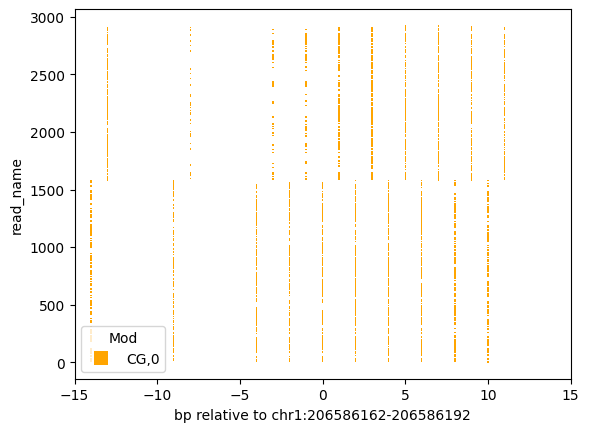

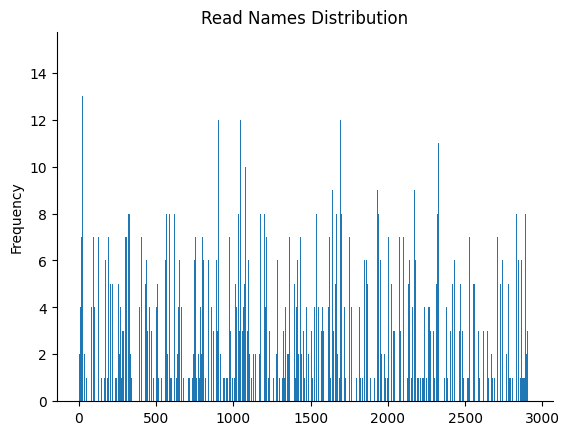

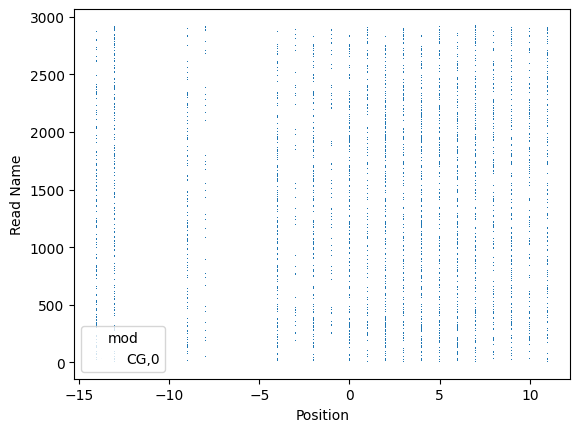

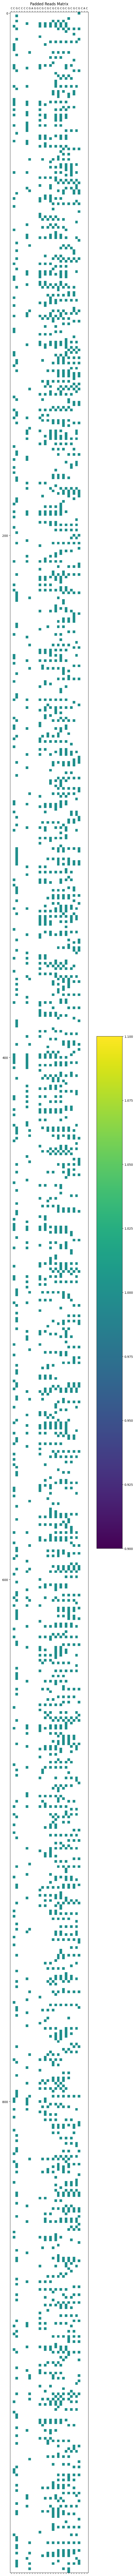

Padded reads saved to padded_reads.npy


In [13]:
import platform
import sys
import pysam
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dimelo import parse_bam, plot_reads, load_processed

def system_info():
    """Print system information."""
    print('System:', platform.system())
    print('Release:', platform.release())
    print('Version:', platform.version())
    print('Processor:', platform.processor())
    print('Python version:', sys.version)

def get_reference_sequence(ref_genome_file,  region_chr, region_start, region_end):
    """Fetch reference sequence from genome file."""
    try:
        ref_seq = pysam.FastaFile(ref_genome_file).fetch(region_chr, region_start, region_end)
        ref_seq_list = list(ref_seq)
        print(ref_seq)
        print(len(ref_seq))
        return ref_seq_list
    except Exception as e:
        print("Error fetching reference sequence:", e)
        return None

def create_output_directory(path):
    """Create output directory if it doesn't exist."""
    try:
        output_dir = Path(path)
        output_dir.mkdir(exist_ok=True)
        return output_dir
    except Exception as e:
        print("Error creating output directory:", e)
        return None

def extract_from_bam(bam_path, ref_genome_file, output_dir, window_size=None, threshold_mC=0.99, 
                    num_cores=32, regions='chr1:206586162-206586192', motifs=['CG,0'], 
                    output_name='extract_output'):
    """Processes a BAM file using parse_bam.extract and plots the extracted reads."""
    try:
        extract_file, extract_regions = parse_bam.extract(
            input_file=bam_path,
            output_name=output_name,
            ref_genome=ref_genome_file,
            output_directory=output_dir,
            regions=regions,
            motifs=motifs,
            thresh=threshold_mC,
            window_size=window_size,
        )

        plot_reads.plot_reads(
            extract_file,
            regions,
            motifs=motifs,
            window_size=window_size,
            sort_by=['shuffle', 'strand'],
            s=1
        )

        plt.xlabel(f'bp relative to {regions}')
        plt.show()

        return extract_file, extract_regions
    except Exception as e:
        print("Error in BAM extraction:", e)
        return None, None

def process_extracted_reads(extract_file, regions, motifs):
    """Process extracted reads into a DataFrame."""
    try:
        reads, read_names, mods, regions_dict = load_processed.readwise_binary_modification_arrays(
            file=extract_file,
            regions=regions,
            motifs=motifs
        )
        df = pd.DataFrame({
            'read_name': read_names,
            'mod': mods,
            'pos': reads
        }).explode('pos')

        df['pos_shifted'] = df['pos'] + 15
        return df, regions_dict
    except Exception as e:
        print("Error processing extracted reads:", e)
        return None, None

def visualize_data(df):
    """Generate visualizations for the data."""
    try:
        df['read_name'].plot(kind='hist', bins=1600, title='Read Names Distribution')
        plt.gca().spines[['top', 'right']].set_visible(False)
        plt.show()

        sns.scatterplot(
            data=df,
            x="pos",
            y="read_name",
            hue="mod",
            s=0.5,
            marker="s",
            linewidth=0
        )
        plt.xlabel('Position')
        plt.ylabel('Read Name')
        plt.show()
    except Exception as e:
        print("Error in visualization:", e)

def create_padded_reads(df, regions_dict, region_length):
    """Generate padded reads matrix."""
    try:
        read_names_unique = np.unique(df['read_name'])
        num_reads = len(read_names_unique)
        reads_dict = {name: i for i, name in enumerate(read_names_unique)}
        padded_reads = np.full((num_reads, region_length), np.nan)

        for i in range(len(df['read_name'])):
            padded_reads[reads_dict[df['read_name'][i]], df['pos_shifted'][i]] = 1

        return padded_reads
    except Exception as e:
        print("Error creating padded reads matrix:", e)
        return None

def plot_padded_reads(padded_reads, ref_seq_list):
    """Plot padded reads matrix using matshow with x-ticks as reference sequence."""
    try:
        plt.figure(figsize=(10, 150))
        plt.matshow(padded_reads, fignum=1)
        plt.colorbar()
        plt.title("Padded Reads Matrix")
        plt.xticks(ticks=np.arange(len(ref_seq_list)), labels=ref_seq_list, size='small') #, rotation=90)
        # plt.xticks(range(len(seq_list)), seq_list, size='small')
        # plt.xlabel("Reference Sequence")

        plt.show()
    except Exception as e:
        print("Error plotting padded reads matrix:", e)

def save_padded_reads(padded_reads, output_dir, file_name):
    """Save padded reads as a NumPy array."""
    try:
        np.save(Path(output_dir, file_name), padded_reads)
        print(f"Padded reads saved to {file_name}")
    except Exception as e:
        print("Error saving padded reads:", e)

def main():
    """Main function to execute all tasks."""
    system_info()

    ref_genome_v1_1_file = Path('/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta')
    # t2t_v1_1_cd55_30bps     # t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'
    region_chr = 'chr1'
    region_start = 206586162
    region_end = 206586192
    region_str = region_chr + ":" + str(region_start) + "-" + str(region_end) #'chr1:206586162-206586192'
    region_length = region_end - region_start
    print("region_length", region_length)

    motifs=['CG,0']
    ref_seq_list = get_reference_sequence(ref_genome_v1_1_file, region_chr, region_start, region_end)

    output_dir = create_output_directory("./dimelo_v2_output")

    unedited_bam_path = "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TcellsPrES_unedit_P2R9/passed_fast5/5mCG/to_t2t_v1_1/sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"

    extract_file, extract_regions = extract_from_bam(
        bam_path=unedited_bam_path,
        ref_genome_file=ref_genome_v1_1_file,
        output_dir=output_dir,
        regions=region_str,
        motifs=motifs,
        output_name='extracted_reads'
    )

    if extract_file:
        df, regions_dict = process_extracted_reads(extract_file, region_str, motifs)
        visualize_data(df)

        padded_reads = create_padded_reads(df, regions_dict, region_length)
        if padded_reads is not None:
            plot_padded_reads(padded_reads, ref_seq_list)
            save_padded_reads(padded_reads, output_dir, "padded_reads.npy")

if __name__ == "__main__":
    main()


In [14]:
import sys
from pathlib import Path

# Add the folder containing 'my_functions.py' to sys.path
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))

# Import the module or specific functions
# from /home/michalula/code/epiCausality/epiCode/utils/funcs_extract_mC_profiles_from_BAMs.py
# from funcs_extract_mC_profiles_from_BAMs import system_info, extract_from_bam
from funcs_extract_mC_profiles_from_BAMs import (
    system_info,
    get_reference_sequence,
    create_output_directory,
    extract_from_bam,
    process_extracted_reads,
    visualize_data,
    create_padded_reads,
    plot_padded_reads,
    save_padded_reads,
    # main,
)

In [15]:
region = ('chr1', 206586162, 206586192)
region

('chr1', 206586162, 206586192)

In [16]:
t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'
t2t_v1_1_cd55_30bps

'chr1:206586162-206586192'